In [21]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os
import datetime
try:
    os.chdir(r'/Users/joan/code/python/jokes-app/src/api')
    path_to_env = "/Users/joan/code/python/jokes-app/config/env-api.env"
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app/src/api')
    path_to_env = "/home/repos/joke-app/config/env-api.env"

In [22]:
import dotenv
dotenv.load_dotenv(dotenv_path=path_to_env)
from src.config import HOST as DB_HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME
DB_HOST = "watxaut.com"

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
import src.db.core as db

### Get connection to Postgres DB

In [25]:
conn = db.connect(host=DB_HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

# USERS

### Get Number of subscribed users and unsubscribed users

In [26]:
df = db.execute_read(conn, "select * from users_mail")

In [27]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

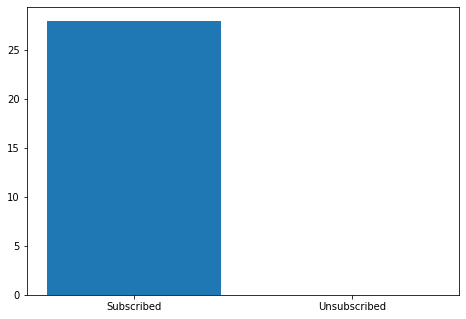

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [29]:
df_mean_user = db.execute_read(conn, """
select 
	split_part(um.email, '@', 1) as user, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [30]:
df_mean_user.head(20)

,user,avg,count
0,watxaut,7.550725,69
1,jaime.conde,1.741667,60
2,irene.chausse,4.982143,56
3,Javier.heras,5.611111,54
4,Extern.javier.gris,5.075472,53
5,adria.hr,4.288462,52
6,antoni.martinezlopez,3.990385,52
7,guillem.mcid,6.865385,52
8,ingrid.falguera19,6.888889,45
9,bcocamarin,7.090909,33


## TOP 5 Most Haters (min 5 reviews)

In [31]:
df_mean_user_min_count = df_mean_user[df_mean_user["count"] >= 5]
df_mean_user_hater = df_mean_user_min_count.sort_values(by=['avg', 'count'])
df_mean_user_hater.head(5)

,user,avg,count
1,jaime.conde,1.741667,60
6,antoni.martinezlopez,3.990385,52
18,alex.colomer.puig,4.150000,20
5,adria.hr,4.288462,52
16,ponsmonica95,4.318182,22


## TOP 5 Supporters (min 5 reviews)

In [32]:
df_mean_user_supporter = df_mean_user_min_count.sort_values(by=['avg', 'count'], ascending=False)
df_mean_user_supporter.head()

,user,avg,count
13,neuscuadernpuig,8.066667,30
0,watxaut,7.550725,69
9,bcocamarin,7.090909,33
19,paucharlez1997,6.941176,17
11,leireberrocal6,6.924242,33


## TOP JOKE SENDERS

In [33]:
sql = """
select 
    split_part(author_email, '@', 1) as user, count(*) as jokes_sent 
from 
    public.jokes_to_send 
where 
    author is not null and
    author_email is not null 
group by author_email 
order by jokes_sent desc
"""
df_marc_senders = db.execute_read(conn, sql)
df_marc_senders.head(5)

,user,jokes_sent
0,Javier.heras,31
1,watxaut,27
2,jaime.conde,17
3,alex.colomer.puig,6
4,Extern.javier.gris,6


# USERS

## AVG joke rating per user

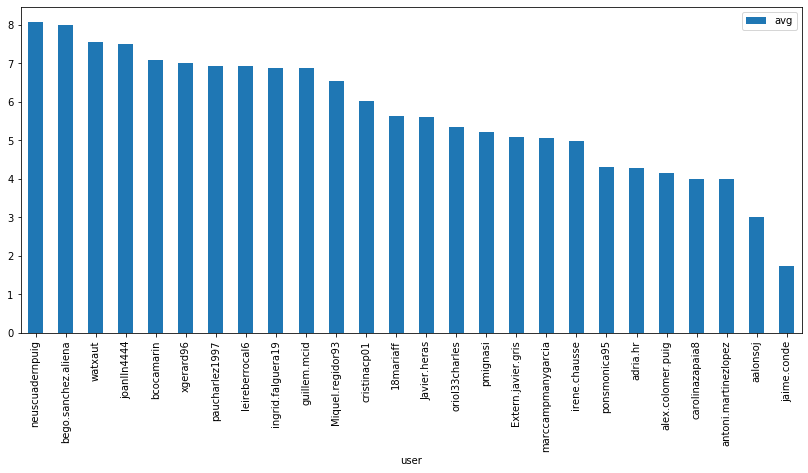

In [34]:
df_mean_user.sort_values(by=['avg'], ascending=False).plot.bar(x="user", y="avg", figsize=(14, 6))

### Rating Statistics

In [35]:
sql = """
select 
	sj.joke_id, r.rating, date(sj.created_at) as day, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail' and sj.sent_from = 'mail'
order by sj.created_at asc
"""
df_ratings = db.execute_read(conn, sql)
df_sent_mails = db.execute_read(conn, "select joke_id, date(created_at) as day from sent_jokes where sent_from = 'mail'")

#### Get last 10 ratings

In [36]:
df_ratings.tail(15)

,joke_id,rating,day,voted_at
792,1838,6.0,2020-01-21,2020-01-21 07:41:10.395426
793,1838,8.0,2020-01-21,2020-01-21 07:45:43.127704
794,1838,8.0,2020-01-21,2020-01-21 07:46:37.495634
795,1838,2.0,2020-01-21,2020-01-21 07:47:06.219447
796,1838,8.0,2020-01-21,2020-01-21 07:51:46.149321
797,1838,3.0,2020-01-21,2020-01-21 07:53:02.023530
798,1838,9.0,2020-01-21,2020-01-21 07:57:56.882141
799,1838,10.0,2020-01-21,2020-01-21 08:15:22.224579
800,1838,4.0,2020-01-21,2020-01-21 08:17:03.807294
801,1838,3.0,2020-01-21,2020-01-21 07:30:51.950121


## Get mean of ratings by joke and day (last 40 natural days)

In [96]:
sql = """
select 
	sj.joke_id, ra.average, ra.std, date(sj.created_at) as day
from 
	sent_jokes sj
left join
	(
		select 
			r.joke_id, avg(r.rating) as average, stddev(r.rating) as std
		from
			ratings as r
		group by r.joke_id
        having count(*) > 5
	) as ra
on (ra.joke_id = sj.joke_id)
where sj.sent_from = 'mail' and ra.average is not null
order by ra.average desc
"""
df_ratings_new = db.execute_read(conn, sql)

In [97]:
df_ratings_new["day"] = df_ratings_new["day"].astype("datetime64")
last_joke_day = list(df_ratings_new.sort_values(ascending=False, by='day').head(1).to_dict(orient="index").values())[0]["day"]

df_ratings_new = df_ratings_new[df_ratings_new["day"] > last_joke_day - pd.Timedelta(days=40)]

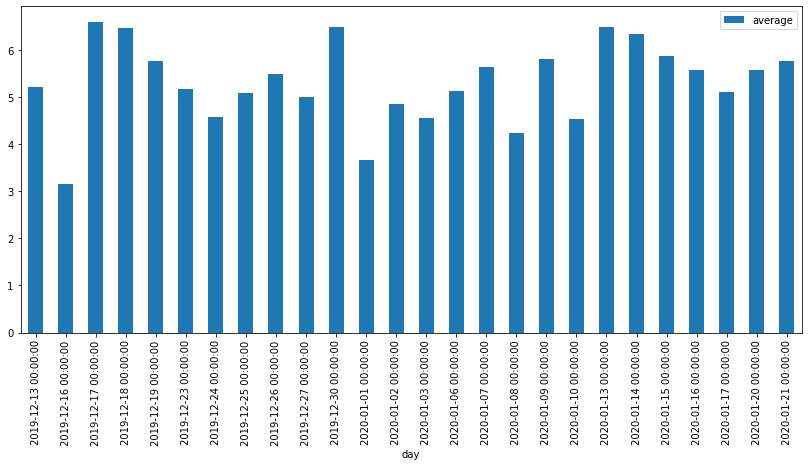

In [98]:
df_ratings_new.sort_values(ascending=True, by='day').plot.bar(x="day", y="average", figsize=(14, 6))

## Get Std Deviation of ratings by joke and day (last 40 natural days)

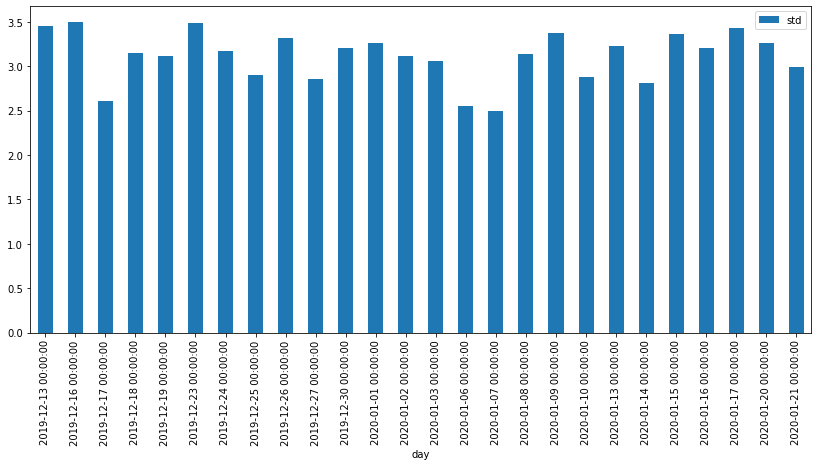

In [99]:
df_ratings_new.sort_values(ascending=True, by='day').plot.bar(x="day", y="std", figsize=(14, 6))

In [100]:
# get worst and best joke from mean - date
d_best = df_ratings_new.head(1).to_dict(orient="index")
best_joke_id = list(d_best.values())[0]["joke_id"]
d_worst = df_ratings_new.tail(1).to_dict(orient="index")
worst_joke_id = list(d_worst.values())[0]["joke_id"]

print(d_best)
print(d_worst)

# get most controversial joke date
d_cont = df_ratings_new.sort_values(ascending=False, by='std').head(1).to_dict(orient="index")
cont_joke_id = list(d_cont.values())[0]["joke_id"]

df_best = db.execute_read(conn, f"select * from jokes_to_send where id = {best_joke_id}")
df_worst = db.execute_read(conn, f"select * from jokes_to_send where id = {worst_joke_id}")
df_cont = db.execute_read(conn, f"select * from jokes_to_send where id = {cont_joke_id}")

{7: {'joke_id': 194, 'average': 6.6, 'std': 2.61315354094845, 'day': Timestamp('2019-12-17 00:00:00')}}
{50: {'joke_id': 1808, 'average': 3.15789473684211, 'std': 3.50020884924087, 'day': Timestamp('2019-12-16 00:00:00')}}


## Best joke of last month

In [102]:
print(f"Joke:\n\n{df_best['joke'][0]}\n\nAuthor: {df_best['author'][0]}\nRating: {list(d_best.values())[0]['average']}")

Joke:

Se abre el telón y aparece un gato que se llama Tido en su cesto.
Se cierra el telón.
Cuando se vuelve a abrir está el cestito pero no el gato.
¿Cómo se llama la película?

El cesto sinTido.

Author: Jaime Con D y Sin D
Rating: 6.6


## Worst joke of all time

In [103]:
print(f"Joke:\n\n{df_worst['joke'][0]}\n\nAuthor: {df_worst['author'][0]}\nRating: {round(list(d_worst.values())[0]['average'], 2)}")

Joke:

¿Cuál es el pescado que no sabe pescar con caña?

El salmonete, porqué dice: 'Sal, monete!'

Author: Ingrid Falguera. Que la democracia decida la suerte del chiste.
Rating: 3.16


## Most controversial of all time

In [104]:
print(f"Joke:\n\n{df_cont['joke'][0]}\n\nAuthor: {df_cont['author'][0]}\nStd dev: {round(list(d_cont.values())[0]['std'], 2)}")

Joke:

¿Cuál es el pescado que no sabe pescar con caña?

El salmonete, porqué dice: 'Sal, monete!'

Author: Ingrid Falguera. Que la democracia decida la suerte del chiste.
Std dev: 3.5
